# West Nile Virus Predictions

### Import Libraries

In [150]:
import sys
# !{sys.executable} -m pip install imblearn

In [151]:
import sys
# !{sys.executable} -m pip install xgboost

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

from datetime import datetime
from datetime import timedelta

### Explore Data

In [153]:
train = pd.read_csv("./all/train.csv")
weather = pd.read_csv("./all/weather.csv")
spray = pd.read_csv("./all/spray.csv")

In [154]:
train.info()
# All variables seem to be the right type of data, no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [155]:
spray.info()
# a few missing rows in our time variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [156]:
weather.info()
# no missing data, but it seems like there are quite a few variables we need to convert to a different type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [157]:
# Get overall picture of our dataset size
train.shape, weather.shape, spray.shape

((10506, 12), (2944, 22), (14835, 4))

In [158]:
# Number of targets in train set
train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [159]:
# The data is unbalanced by checking the percentage of 1s
551 / (551 + 9955)

0.05244622120692937

In [160]:
# Let's convert our dates to datetime for easier EDA
train.Date = pd.to_datetime(train.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

### Visualizations

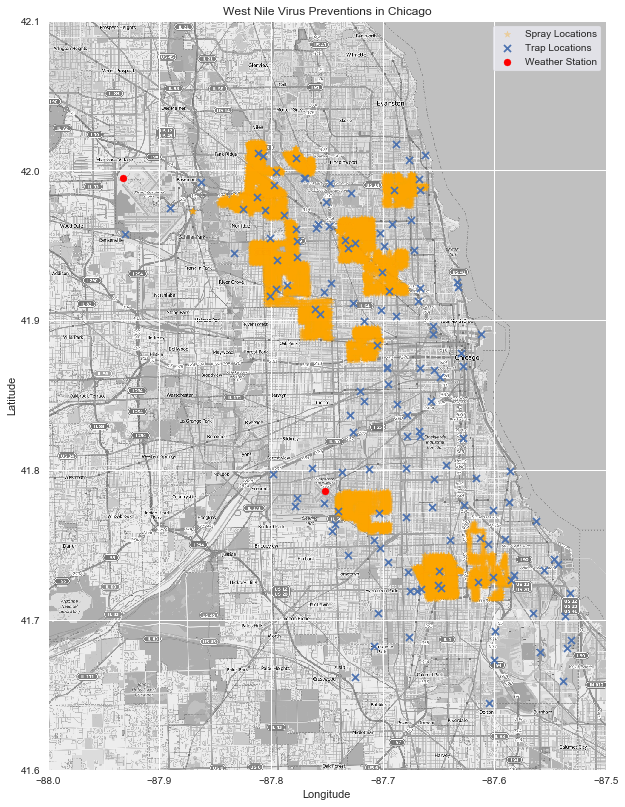

In [161]:
# Load map data
mapdata = np.loadtxt("./all/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('./all/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Plot map
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# Spray locations
sprays = spray[['Longitude', 'Latitude']].drop_duplicates()
sprays = sprays[sprays['Latitude'] < 42.3]  #outliers excluded
plt.scatter(sprays['Longitude'], sprays['Latitude'], marker='*', color='orange',alpha=.3, label='Spray Locations')

# Trap locations
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Locations')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='r', label='Weather Station')
            
plt.title('West Nile Virus Preventions in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png');

We wanted to get a better depiction of what our data was telling us geographically. The blue Xs indicate traps placed for catching mosquitoes. Orange markings describe the areas that were sprayed and the two red circles are where the weather stations are at. The traps are pretty spread out compared to where the sprays are at. There must be a reason for this, let's see if any other visuals will help explain this mystery. 

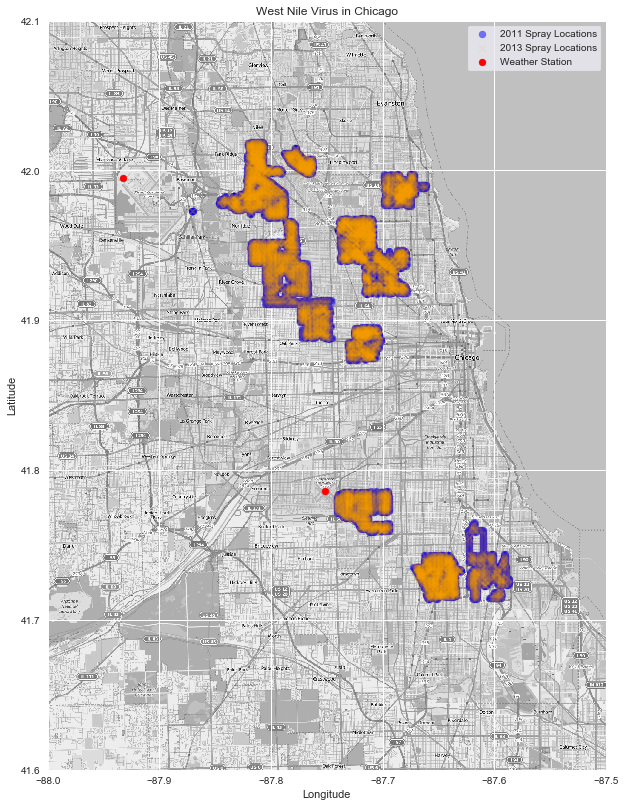

In [162]:
spray['year'] = spray['Date'].dt.year
spray_2011 = spray[spray['year'] == 2011]
spray_2013 = spray[spray['year'] == 2013]

# Plot map
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# Spray locations
sprays_2011 = spray_2011[['Longitude', 'Latitude']].drop_duplicates()
sprays_2013 = spray_2013[['Longitude', 'Latitude']].drop_duplicates()
sprays_2011 = sprays[sprays['Latitude'] < 42.3]  #outliers excluded
sprays_2013 = sprays[sprays['Latitude'] < 42.3] 
plt.scatter(sprays_2011['Longitude'], sprays_2011['Latitude'], marker='o', color='blue',alpha=.5, label='2011 Spray Locations')
plt.scatter(sprays_2013['Longitude'], sprays_2013['Latitude'], marker='x', color='orange',alpha=.08, label='2013 Spray Locations')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='r', label='Weather Station')
            
plt.title('West Nile Virus in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png');

The spray data contains only two years: 2011 (blue) and 2013(orange). This graph basically is to explore if there was any differences in what they did in the two years. From the looks of it, there is practically no difference, they sprayed the same location in both years. 

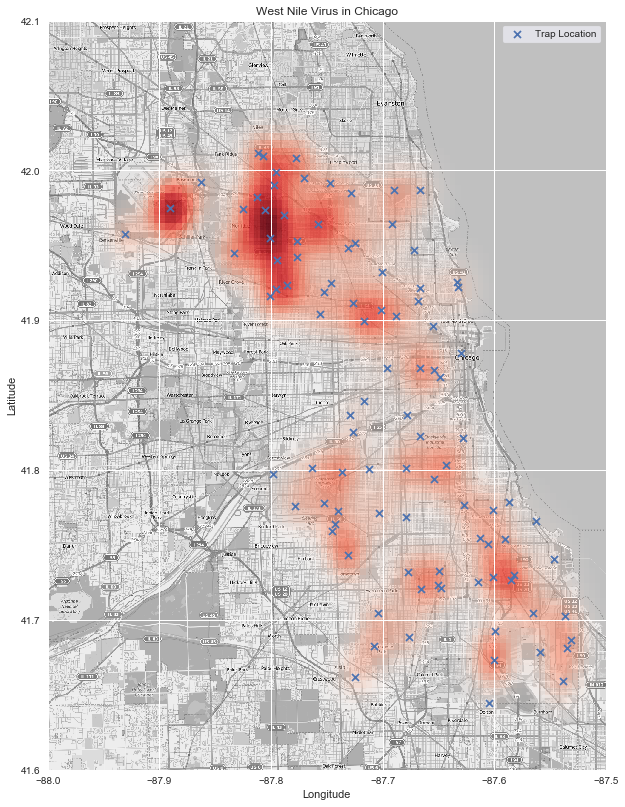

In [235]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
sigthings = traps[traps['WnvPresent'] == 1]
sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X = sigthings[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = sigthings[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')


plt.title('West Nile Virus in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png')

This heatmap helps identify the density and clustering of traps with mosquitos with west nile virus. Areas with a darker red indicates that the region has more mosquitoes with the virus and areas with less red means less virus. The graph helps with indicating which areas have a higher priority when it comes to anti WNV sprays.  

### More EDA

We want to be able to combine our datasets into one big one. We will clean the weather dataset first and conduct any feature engineering needed before merging into our training set

In [164]:
#check columns for the value with M
object_features = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'AvgSpeed']
for col in weather[object_features]:
    station_1 = len(weather[(weather[col].str.contains('M')) & (weather.Station==1)])
    print(col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('M')) & (weather.Station==2)])
    print(col + ' has ' + str(station_2) + ' missing values at station 2')

Tavg has 0 missing values at station 1
Tavg has 11 missing values at station 2
Depart has 0 missing values at station 1
Depart has 1472 missing values at station 2
WetBulb has 3 missing values at station 1
WetBulb has 1 missing values at station 2
Heat has 0 missing values at station 1
Heat has 11 missing values at station 2
Cool has 0 missing values at station 1
Cool has 11 missing values at station 2
Sunrise has 0 missing values at station 1
Sunrise has 0 missing values at station 2
Sunset has 0 missing values at station 1
Sunset has 0 missing values at station 2
CodeSum has 3 missing values at station 1
CodeSum has 0 missing values at station 2
Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2
Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2
SnowFall has 0 missing values at station 1
SnowFall has 1472 missing values at station 2
PrecipTotal has 0 missing values at station 1
PrecipTotal has 2 missing values at st

M stands for missing data as mentioned in the data description. Looks like we have quite a few missing data in a few of the features, mainly for station 2. We might consider just dropping certain features or filling in the missing values with the mean of the column.

In [165]:
#check columns for values with T
for col in weather[object_features]:
    station_1 = len(weather[(weather[col].str.contains('T')) & (weather.Station==1)])
    print(col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('T')) & (weather.Station==2)])
    print(col + ' has ' + str(station_2) + ' missing values at station 2')

Tavg has 0 missing values at station 1
Tavg has 0 missing values at station 2
Depart has 0 missing values at station 1
Depart has 0 missing values at station 2
WetBulb has 0 missing values at station 1
WetBulb has 0 missing values at station 2
Heat has 0 missing values at station 1
Heat has 0 missing values at station 2
Cool has 0 missing values at station 1
Cool has 0 missing values at station 2
Sunrise has 0 missing values at station 1
Sunrise has 0 missing values at station 2
Sunset has 0 missing values at station 1
Sunset has 0 missing values at station 2
CodeSum has 174 missing values at station 1
CodeSum has 179 missing values at station 2
Depth has 0 missing values at station 1
Depth has 0 missing values at station 2
Water1 has 0 missing values at station 1
Water1 has 0 missing values at station 2
SnowFall has 12 missing values at station 1
SnowFall has 0 missing values at station 2
PrecipTotal has 163 missing values at station 1
PrecipTotal has 155 missing values at station 2
S

In [166]:
#features that are objects
weather.select_dtypes(include='object').columns

Index(['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'AvgSpeed'],
      dtype='object')

In [167]:
#columns to replace values of M, T, - 
columns = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
           'SnowFall', 'PrecipTotal', 'StnPressure','SeaLevel', 'AvgSpeed']

# run through all of these columns
for column in columns:
    weather.replace({'M': None}, inplace = True)
    weather.replace({'T': '0.00001'}, inplace = True)
    weather.replace({'  T': '0.00001'}, inplace = True)
    weather.replace({'-': None}, inplace = True)

In [168]:
# I didn't find these columns useful at all, decided to drop because there are too many missing values
weather.drop(columns= ['CodeSum', 'Depth', 'Water1'],inplace=True)

In [169]:
# convert columns to float type and fill any null values with the mean of the column
for column in columns:
    weather[column] = weather[column].astype(float)
    weather[column] = weather[column].fillna(weather[column].mean(skipna = True))

At this point, we need to decide whether to just choose one weather station or include both. We decided to get the average of the two weather stations because that seemed to get the best of both worlds and perhaps will be a better estimate of the weather. Also, when merging datasets we will merge on the date, taking the average of the two stations will make the data combining easier.

In [170]:
#create new dataframe with the average of columns for the two weather stations
weather_both = pd.DataFrame()
station_1 = weather[weather['Station'] == 1].reset_index()
station_2 = weather[weather['Station'] == 2].reset_index()
weather_both['Date'] = station_1['Date']

def avg_station(df):
    for col in df:
        weather_both[col] = (station_1[col] + station_2[col])*.5

In [171]:
# apply function
avg_station(weather.drop(['Date','Station'],axis=1))

With a little research, we decided that the number of days since it rained might have an impact on the number of misquitos. Thus, we decided to create another feature below for this reason.

In [172]:
# create a column for the days since it last rained
weather_both["days_since_rain"] = 0
days = 0

for i in range(weather_both.shape[0]):
    if weather_both.loc[i,'PrecipTotal'] == 0:
        days = days + 1
        weather_both.loc[i,'days_since_rain'] = days
    else:
        weather_both.loc[i, 'days_since_rain'] = 0
        days=0

In [173]:
#check to make sure everything is good so far
weather_both.head(2)

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,days_since_rain
0,2007-05-01,83.5,51.0,67.5,7.977242,51.0,56.5,0.0,2.5,464.32337,1848.173913,0.000034,0.0,29.14,29.820,2.20,26.0,9.4,1
1,2007-05-02,59.5,42.5,51.5,-0.522758,42.0,47.0,13.5,0.0,463.82337,1848.673913,0.000034,0.0,29.41,30.085,13.15,3.0,13.4,2


We also wanted to see the effect of shifting time forward or whether a lagged weather feature in a given number of days would impact the number of mosquitos. The code below shows our approach to applying this method.

In [174]:
# set a new dataframe for the features i want to do a time lag on
var = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'SnowFall',
       'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

lag_features = weather_both[var]

In [175]:
# set the number of lags i want, these are the lags in days
lags = (1,3,7,14)

# set to a final dataframe
# .assign assigns new columns to the dataframe, after that is a list comprehension
# f'{col}_lag_{n}' <-- f' string feature to assign column name, its like .format()
# list comp <-- for every column shift down for every lag
final_weather = weather_both.assign(**{f'{col}_lag_{n}': 
                                       lag_features[col].shift(n) for n in lags for col in lag_features})

In [176]:
# merges the two datasets together (train and final weather data)
result = train.merge(final_weather, on='Date')

We figured the length of a day would be another feature to include because that would encompass the entire timeframe in which the sun was applying heat. From outside research, heat usually has a strong correlation with the number of mosquitos

In [177]:
# function for how long a day is in minutes
def day_length(row):
    sunset = (round(row.Sunset / 100) * 60)
    sunrise = (round(row.Sunrise / 100) * 60)
    return int(abs(sunset - sunrise))

In [178]:
# apply the function
result['day_length'] = result.apply(day_length, axis=1)

In [179]:
result.select_dtypes(include='object').columns

Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet'], dtype='object')

In [180]:
result.select_dtypes(include=['float64', 'int64']).columns

Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'days_since_rain', 'Tmax_lag_1', 'Tmin_lag_1', 'Tavg_lag_1',
       'DewPoint_lag_1', 'WetBulb_lag_1', 'SnowFall_lag_1',
       'PrecipTotal_lag_1', 'SeaLevel_lag_1', 'ResultSpeed_lag_1',
       'ResultDir_lag_1', 'AvgSpeed_lag_1', 'Tmax_lag_3', 'Tmin_lag_3',
       'Tavg_lag_3', 'DewPoint_lag_3', 'WetBulb_lag_3', 'SnowFall_lag_3',
       'PrecipTotal_lag_3', 'SeaLevel_lag_3', 'ResultSpeed_lag_3',
       'ResultDir_lag_3', 'AvgSpeed_lag_3', 'Tmax_lag_7', 'Tmin_lag_7',
       'Tavg_lag_7', 'DewPoint_lag_7', 'WetBulb_lag_7', 'SnowFall_lag_7',
       'PrecipTotal_lag_7', 'SeaLevel_lag_7', 'ResultSpeed_lag_7',
       'ResultDir_lag_7', 'AvgSpeed_lag_7', 'Tmax_lag_14', 'Tmin_lag_14',
      

In [181]:
#final shape of our dataframe
result.shape

(10506, 75)

In [182]:
# Identify columns of the highest correlation to 'WNVPresent'
columns_high_corr = abs(result.corr()["WnvPresent"]).sort_values(ascending=False).round(3).index[2:40]

In [183]:
# check number of WNV 
result["WnvPresent"].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

### Models

In [184]:
# Create a variable containing only the columns with high correlation 
training_features = result[columns_high_corr]
training_target = result["WnvPresent"]
training_features.shape

In [186]:
x_train, x_test, y_train, y_test = train_test_split(training_features, training_target,
                                                  test_size = .2,
                                                  random_state=11, shuffle = True)

### Oversampling 

In [236]:
# check number of WNV and this is an unbalanced dataset
result["WnvPresent"].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [187]:
# Oversample the data to create balanced dataset to fit the models
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_mod, y_train_mod = sm.fit_sample(x_train, y_train)
x_test_mod, y_test_mod = sm.fit_sample(x_test, y_test)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [188]:
# convert train data back to pandas instead of numpy arrays
x_train_mod_pd = pd.DataFrame(x_train_mod)
x_train_mod_pd.columns = x_train.columns
y_train_mod_pd = pd.Series(y_train_mod)

### Logistic Regression

In [189]:
lg = LogisticRegression()

print("Cross validation on over sampled train data:\n",cross_val_score(lg, x_train_mod,y_train_mod,n_jobs=-1, cv = 10).round(3),"\n")

print("Cross validation on test data: \n", cross_val_score(lg, x_test,y_test,n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on over sampled train data:
 [0.768 0.754 0.763 0.753 0.751 0.759 0.768 0.758 0.755 0.768] 

Cross validation on test data: 
 [0.948 0.948 0.948 0.948 0.952 0.952 0.952 0.952 0.952 0.952] 



In [190]:
lg.fit(x_train_mod, y_train_mod)
predicted = lg.predict(x_train_mod)
print("R2 score on train dataset: ", lg.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod, predicted).round(3))

R2 score on train dataset:  0.762
ROC score on train dataset:  0.762


In [191]:
print("R2 score on test dataset: ", lg.score(x_test, y_test).round(3))
predicted = lg.predict(x_test)
print("ROC score on test dataset: ",roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.704
ROC score on test dataset:  0.753


 Logistic regression does an OK job here.

### Gradient Boosting Classifier

In [193]:
gbc = GradientBoostingClassifier()
print("Cross validation on train dataset: \n", cross_val_score(gbc, x_train_mod,y_train_mod, n_jobs=-1, cv = 10).round(3), "\n")
print("Cross validation on test dataset: \n", cross_val_score(gbc, x_test,y_test, n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on train dataset: 
 [0.805 0.827 0.837 0.823 0.823 0.833 0.83  0.833 0.83  0.836] 

Cross validation on test dataset: 
 [0.957 0.943 0.948 0.943 0.948 0.957 0.952 0.948 0.952 0.943] 



In [194]:
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.834
ROC score on train dataset:  0.834


In [195]:
predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.765
ROC score on test dataset:  0.758


In [196]:
# Using gridsearch CV to optimize results
score_function = make_scorer(roc_auc_score)
params_gbc = {
    "gbc__learning_rate"  : [1],
    "gbc__n_estimators"     : [10, 100, 300],
    "gbc__max_depth"  : [3, 10],
    "gbc__random_state"    : [42]
             }
steps_gbc = [('gbc', GradientBoostingClassifier())]
pipe_gbc = Pipeline(steps = steps_gbc)
gs_gbc = GridSearchCV(pipe_gbc, param_grid = params_gbc , scoring = score_function, verbose=1)

In [197]:
gs_gbc.fit(x_train_mod, y_train_mod)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
 ...     presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gbc__learning_rate': [1], 'gbc__n_estimators': [10, 100, 300], 'gbc__max_depth': [3, 10], 'gbc__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [198]:
gs_gbc.best_params_

{'gbc__learning_rate': 1,
 'gbc__max_depth': 10,
 'gbc__n_estimators': 300,
 'gbc__random_state': 42}

In [199]:
# Test gbc using gridserachcv updated results
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42, max_depth=10)
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.958
ROC score on train dataset:  0.958


In [200]:
predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.897
ROC score on test dataset:  0.627


In [237]:
# Other test results are listed below:

In [201]:
# Fine tune on accuracy score:
# {'gbc__learning_rate': 0.1,
# 'gbc__max_depth': 10,
# 'gbc__n_estimators': 500,
# 'gbc__random_state': 42}
# R2 score on train dataset:  0.903
# ROC score on train dataset:  0.903
# R2 score on test dataset:  0.846
# ROC score on test dataset:  0.682   too bad on ROC score, switch to ROC score for score function

In [202]:
# gbc = GradientBoostingClassifier(learning_rate=1, n_estimators=100, random_state=42, max_depth=10)
# R2 score on train dataset:  0.962
# ROC score on train dataset:  0.962
# R2 score on test dataset:  0.903
# ROC score on test dataset:  0.625

In [203]:
# gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, random_state=42, max_depth=10)
# R2 score on train dataset:  0.965
# ROC score on train dataset:  0.965
# R2 score on test dataset:  0.92
# ROC score on test dataset:  0.607

In [204]:
# GridsearchCV updated results are worse on ROC score on test dataset, the default parameters give best scores.

### Random Forest Classifier

In [205]:
rfc = RandomForestClassifier()
print("Cross validation score on train dataset: ", cross_val_score(rfc, x_train_mod,y_train_mod, n_jobs=-1).round(3), "\n")
print("Cross validation score on test dataset: ", cross_val_score(rfc, x_test,y_test, n_jobs=-1).round(3), "\n")

Cross validation score on train dataset:  [0.845 0.861 0.865] 

Cross validation score on test dataset:  [0.93  0.929 0.941] 



In [206]:
rfc.fit(x_train_mod, y_train_mod)
print("R2 score on train dataset: ", rfc.score(x_train_mod, y_train_mod).round(3))
predicted = rfc.predict(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted).round(3))

R2 score on train dataset:  0.954
ROC score on train dataset:  0.805


In [207]:
print("R2 score on test dataset: ", rfc.score(x_test, y_test).round(3))
predicted = rfc.predict(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.887
ROC score on test dataset:  0.64


In [208]:
# Random Forest doesn't perform well on ROC scores

### XGBOOST Model

In [209]:
xgb = XGBClassifier(n_estimators = 500)
xgb.fit(x_train_mod_pd, y_train_mod_pd)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [210]:
print("R2 score on train dataset: ", xgb.score(x_train_mod_pd, y_train_mod_pd).round(3))
predicted = xgb.predict(x_train_mod_pd)
print("ROC score on train dataset: ", roc_auc_score(y_train_mod_pd, predicted).round(3))

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


R2 score on train dataset:  0.885
ROC score on train dataset:  0.885


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [211]:
print("R2 score on test dataset: ", xgb.score(x_test, y_test).round(3))
predicted = xgb.predict(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.829
ROC score on test dataset:  0.718


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [212]:
# XGBOOST default paramters:
# R2 score on train dataset:  0.827
# ROC score on train dataset:  0.827
# R2 score on test dataset:  0.754
# ROC score on test dataset:  0.761
# Kaggle submission score: 0.73160

In [213]:
# XGBOOST n_estimators = 500
# R2 score on train dataset:  0.885
# ROC score on train dataset:  0.885
# R2 score on test dataset:  0.829
# ROC score on test dataset:  0.718
# Kaggle submission score : 0.68824

In [214]:
# XGBOOST max_depth = 7
# R2 score on train dataset:  0.89
# ROC score on train dataset:  0.89
# R2 score on test dataset:  0.819
# ROC score on test dataset:  0.7
# Kaggle submission score : 0.65779

In [215]:
# XGBoost performs reasonably as good as Gradient Descent with default parameters and the attempts to tuning paramters
# all failed to generate better results.

### Test Data

In [216]:
test_kaggle = pd.read_csv("./all/test.csv")

In [217]:
test_kaggle.shape

(116293, 11)

In [218]:
test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [219]:
# We need to apply the same feature engineering steps for better prediction
test_kaggle.Date = pd.to_datetime(test_kaggle.Date)

In [221]:
#Apply same engineered features to test set 
test_feat_eng = test_kaggle.merge(final_weather, on='Date')
test_feat_eng['day_length'] = test_feat_eng.apply(day_length, axis=1)
test_feat_eng = test_feat_eng[columns_high_corr]

#add predicted WNV column to test df
test_kaggle['Predicted_wnv'] = gbc.predict(test_feat_eng)

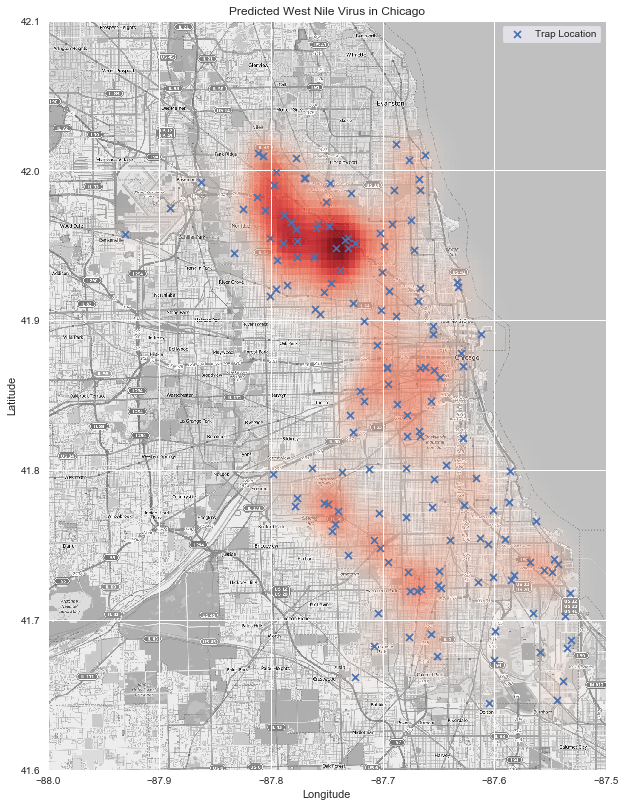

In [227]:
test_traps = test_kaggle[['Date', 'Trap','Longitude', 'Latitude', 'Predicted_wnv']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
sigthings = test_traps[test_traps['Predicted_wnv'] == 1]
sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['Predicted_wnv'].reset_index()
X = sigthings[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = sigthings[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')


plt.title('Predicted West Nile Virus in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('predicted_heatmap.png')

This heatmap shows the predicted areas in which there will be WNV for the next year based off of our model

### Submission for Kaggle

** GBC submission **

In [228]:
submission = pd.DataFrame(gbc.predict_proba(test_feat_eng)[:,1], columns = ['WnvPresent'])

In [229]:
submission.set_index(np.arange(1, test_feat_eng.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission_gbc_default.csv', index = False)

** XGBOOST Submission **

In [ ]:
submission = pd.DataFrame(xgb.predict_proba(test_feat_eng)[:,1], columns = ['WnvPresent'])
submission.set_index(np.arange(1, test_feat_eng.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission_xgb_n_estimators_500.csv', index = False)

** Logistic Regression Submission **

In [ ]:
submission = pd.DataFrame(lg.predict_proba(test_feat_eng)[:,1], columns = ['WnvPresent'])
submission.set_index(np.arange(1, test_feat_eng.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission_logistic_regression.csv', index = False)

In [ ]:
# Kaggle score: 0.70791